In [170]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from sklearn.preprocessing import StandardScaler
# import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gpytorch
from scipy.linalg import solve
from gpytorch.kernels import RBFKernel,ScaleKernel,LinearKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from collections import namedtuple, deque


from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, clear_output

In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [172]:
# Define training parameters
num_episodes = 600
max_steps_per_episode = 200
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay_rate = 0.996
gamma = 0.95
lr = 0.0025
buffer_size = 50000
buffer = deque(maxlen=buffer_size)
batch_size = 100
update_frequency = 10
nrow=20
ncol=20
CI_parameter=0.6
#GP discretization bound
Position_lb=-4.8
Position_ub=4.8

Velocity_lb=-10000
Velocity_ub=10000
Pole_Angle_ld= -0.418 
Pole_Angle_rd= 0.418 



Pole_Angle_Velocity_lb= -10000
Pole_Angle_Velocity_ub=10000



Position_safe_lb=-1.9
Position_safe_ub=1.9
Pole_Angle_safe_ld= -0.15
Pole_Angle_safe_ud=   0.15



safety_bound=0.3

In [173]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.to(device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
#for precition   
# @variational_estimator
# class BayesianRegressor(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         #self.linear = nn.Linear(input_dim, output_dim)
#         self.blinear1 = BayesianLinear(input_dim,64)
#         self.blinear2 = BayesianLinear(64, output_dim)
        
#     def forward(self, x):
#         x_ = self.blinear1(x)
#         x_ = F.relu(x_)
#         return self.blinear2(x_)
    
# def evaluate_regression(regressor,
#                         X,
#                         y,
#                         samples = 100,
#                         std_multiplier = 2):
#     preds = [regressor(X) for i in range(samples)]
#     preds = torch.stack(preds)
#     means = preds.mean(axis=0)
#     stds = preds.std(axis=0)
#     ci_upper = means + (std_multiplier * stds)
#     ci_lower = means - (std_multiplier * stds)
#     ic_acc = (ci_lower <= y) * (ci_upper >= y)
#     ic_acc = ic_acc.float().mean()
#     return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

# def evaluate_CI(regressor,
#                         state,action,
#                         samples = 100,
#                         std_multiplier = 2):
#     X=np.concatenate((state, np.array(action).reshape(1, )), axis=0)
#     X_tensor=torch.from_numpy(X).float().unsqueeze(0).to(device)
#     preds = [regressor(X_tensor) for i in range(samples)]
#     preds = torch.stack(preds)
#     means = preds.mean(axis=0)
#     stds = preds.std(axis=0)
#     ci_upper = means + (std_multiplier * stds)
#     ci_lower = means - (std_multiplier * stds)
#     return means,ci_lower,ci_upper

def cal_cost(state,action,next_state):
    cost1=0
    cost2=0
    if Position_safe_lb >=next_state[0]:
        cost1=Position_safe_lb-next_state[0]
    if Position_safe_ub <=next_state[0]:
        cost1=next_state[0]-Position_safe_ub
    if next_state[2]<=Pole_Angle_safe_ld:
        cost2=Pole_Angle_safe_ld-next_state[2]
    if next_state[2]>=Pole_Angle_safe_ud:
        cost2=next_state[2]-Pole_Angle_safe_ud
    return np.maximum(cost1,10*cost2)
       

class ProbabilisticRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, 1)
        self.log_var_head = nn.Linear(hidden_dim, 1)  # log variance for stability

    def forward(self, x):
        h = self.shared(x)
        mean = self.mean_head(h)
        log_var = self.log_var_head(h)
        return mean, log_var  # we return log variance to keep it numerically stable
    
def gaussian_nll_loss(y_pred_mean, y_pred_log_var, y_true):
    # NLL for a Gaussian: log(sigma^2) + (y - mu)^2 / sigma^2
    loss = 0.5 * (y_pred_log_var + ((y_true - y_pred_mean) ** 2) / torch.exp(y_pred_log_var))
    return loss.mean()

In [175]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [176]:
# Define the DQN agent class
class DQNAgent:
    # Initialize the DQN agent
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    # Choose an action based on the current state
    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)
        
    # Choose an safe action based on the current state and prediction
    def act_safe(self, state, model, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()
        
        possible_action=np.ones(self.action_size)
        for i in range(self.action_size):
            X=np.concatenate((state, np.array(i).reshape(1, )), axis=0)
            X_tensor=torch.from_numpy(X).float().unsqueeze(0).to(device)
            mean, log_var = model(X_tensor)
            ub= mean.item()+CI_parameter*np.sqrt(np.exp(log_var.item()))
            if ub>=safety_bound:
                possible_action[i]=0 
                # action_values[0][i]=-1
               
        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:

            if np.sum(possible_action)==0:
                return action_values.argmax(dim=1).item()
            else:
                a=np.random.choice(self.action_size,size=1,p=possible_action/np.sum(possible_action))[0]
                return int(a)
            # return np.random.randint(self.action_size)
    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [177]:
# Set up the environment
env = gym.make("CartPole-v1", render_mode="rgb_array")


# Initialize the DQNAgent
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
new_agent = DQNAgent(input_dim, output_dim, seed=170715, lr = lr)

# Initialize the GP
# mean_block=np.zeros((num_episodes+1,nrow,ncol))
# cov_block=np.zeros((num_episodes+1,nrow,ncol,nrow,ncol))
sigma_noise=0.1


#Initialize the BNN
# regressor = BayesianRegressor(input_dim+1, 1)
# optimizer = optim.Adam(regressor.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()



#Initialize the Prediction NN
model = ProbabilisticRegressor(input_dim=5, hidden_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [178]:
def gauss_fit(mu_input,cov_input,data_block,n_visit_block):
    mu=np.copy(mu_input)
    cov=np.copy(cov_input)
    new_mu=np.zeros((nrow,ncol))
    new_cov=np.zeros((nrow,ncol,nrow,ncol))

    # for s in initial_gauss_set:
    #     visit_set[to_row_col(s)[0],to_row_col(s)[1]]=1
    for row in range(nrow):
        for col in range(ncol):
            if  n_visit_block[row,col]>0:
                y=np.copy(data_block[row,col])
                new_mu=mu+cov[:,:,row,col]/(cov[row,col,row,col]+sigma_noise)*(y-mu[row,col])
                new_mu[row,col]=np.copy(y)
                for j1 in range(nrow):
                    for k1 in range(ncol):
                        for j2 in range(nrow):
                            for k2 in range(ncol):
                                new_cov[j1,k1,j2,k2]=cov[j1,k1,j2,k2]-cov[j1,k1,row,col]*cov[j2,k2,row,col]/(cov[row,col,row,col]+sigma_noise)
                mu=np.copy(new_mu)
                cov=np.copy(new_cov)

    return mu, cov

In [179]:
# for  i1 in range(nrow):
#     for j1 in range(ncol):
#         for  i2 in range(nrow):
#             for j2 in range(ncol):
#                 cov_block[0,i1,j1,i2,j2]=np.exp(-(i1-i2)**2/50-(j1-j2)**2/50)

In [180]:
np.random.seed(0)
iteration = np.zeros(num_episodes)
violation=np.zeros(num_episodes)
for episode in range(num_episodes): #Gym versions >= 0.26 where env.reset() returns a tuple (obs, info)
    # Reset the environment
    state = env.reset()[0] #shape(4,)
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay_rate ** episode))

    # Run one episode
    for step in range(max_steps_per_episode):
        # Choose and perform an action
        action = new_agent.act_safe(state, model,epsilon)# int
        # action = new_agent.act(state,epsilon)# int
        next_state, reward, done, truncated, _ = env.step(action)
        cost=cal_cost(state,action,next_state)
        buffer.append((state, action, reward-50*cost, next_state, done))
        
        if cost>safety_bound:
            violation[episode]+=1


        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            # Update the agent's knowledge
            new_agent.learn(batch, gamma)
        
        #train BNN
        datapoints=np.concatenate((state, np.array(action).reshape(1, )), axis=0)
        data_tensor = torch.from_numpy(datapoints).float().unsqueeze(0).to(device)
        labels=np.array(cost).reshape(1,)
        labels_tensor=torch.from_numpy(labels).float().unsqueeze(0).to(device)

        optimizer.zero_grad()
        mean, log_var = model(data_tensor)
        loss = gaussian_nll_loss(mean, log_var, labels_tensor)
        loss.backward()
        optimizer.step()
        iteration[episode]+=1

        # optimizer.zero_grad()
        # data_tensor = torch.from_numpy(datapoints).float().unsqueeze(0).to(device)
        # loss = regressor.sample_elbo(inputs=data_tensor.to(device),
        #                    labels=labels_tensor.to(device),
        #                    criterion=criterion,
        #                    sample_nbr=10,
        #                     complexity_cost_weight=1)
        # loss.backward()
        # optimizer.step()
        # iteration += 1
        # if iteration%100==0:
        #     ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
        #                                                                 X_test,
        #                                                                 y_test,
        #                                                                 samples=25,
        #                                                                 std_multiplier=3)
        state = next_state
        
        # Check if the episode has ended
        if done:
            break
    
    if (episode + 1) % update_frequency == 0:
        print(f"Episode {episode + 1}: Finished training")

Episode 10: Finished training
Episode 20: Finished training
Episode 30: Finished training
Episode 40: Finished training
Episode 50: Finished training
Episode 60: Finished training
Episode 70: Finished training
Episode 80: Finished training
Episode 90: Finished training
Episode 100: Finished training
Episode 110: Finished training
Episode 120: Finished training
Episode 130: Finished training
Episode 140: Finished training
Episode 150: Finished training
Episode 160: Finished training
Episode 170: Finished training
Episode 180: Finished training
Episode 190: Finished training
Episode 200: Finished training
Episode 210: Finished training
Episode 220: Finished training
Episode 230: Finished training
Episode 240: Finished training
Episode 250: Finished training
Episode 260: Finished training
Episode 270: Finished training
Episode 280: Finished training
Episode 290: Finished training
Episode 300: Finished training
Episode 310: Finished training
Episode 320: Finished training
Episode 330: Fini

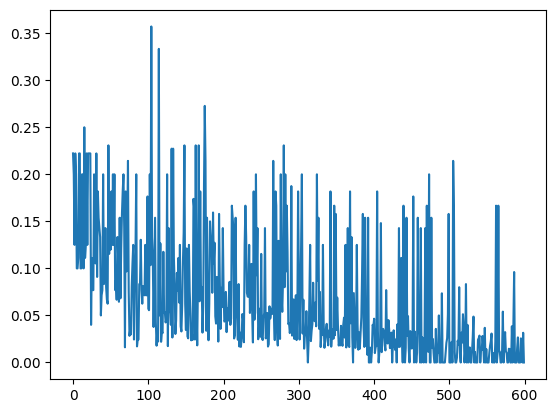

In [181]:
plt.plot(violation/iteration)

In [182]:
np.sum(violation),np.sum(iteration)

(1707.0, 53733.0)

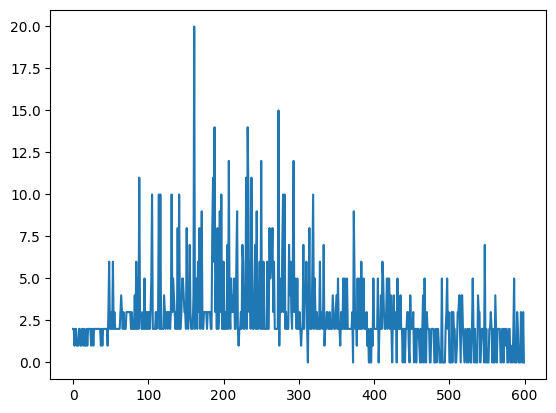

In [183]:
plt.plot(violation)

In [184]:
state = env.reset()[0]
action=1
next_state=state

In [185]:
state=next_state
next_state, reward, done, truncated, _ = env.step(action)
state,action,next_state

(array([-0.01904916, -0.02583755,  0.0376992 ,  0.02838253], dtype=float32),
 1,
 array([-0.01956591,  0.16872406,  0.03826685, -0.25217158], dtype=float32))

In [186]:

X=np.concatenate((state, np.array(action).reshape(1, )), axis=0)
X_tensor=torch.from_numpy(X).float().unsqueeze(0).to(device)
mean, log_var = model(X_tensor)
mean.item(), np.exp(log_var.item())

(-0.05491967499256134, 0.0011743032029227858)

In [187]:
state_tensor=torch.from_numpy(state).float().unsqueeze(0).to(device)

act_value=new_agent.qnetwork_local(state_tensor)

In [194]:
# Evaluate the agent's performance
np.random.seed(2025)
test_episodes = 100
max_steps_per_test_episode=1000
episode_rewards = []
test_epi_length=np.zeros(test_episodes)
for episode in range(test_episodes):
    state = env.reset()[0]
    episode_reward = 0
    done = False
    for step in range(max_steps_per_test_episode):
   
        # action = new_agent.act_safe(state, model,eps=0)
        action = new_agent.act(state,eps=0)
        next_state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
        state = next_state
        test_epi_length[episode]+=1
        if done:
            break
        
    episode_rewards.append(episode_reward)

average_reward = sum(episode_rewards) / test_episodes
print(f"Average reward over {test_episodes} test episodes: {average_reward:.2f}")

Average reward over 100 test episodes: 148.82


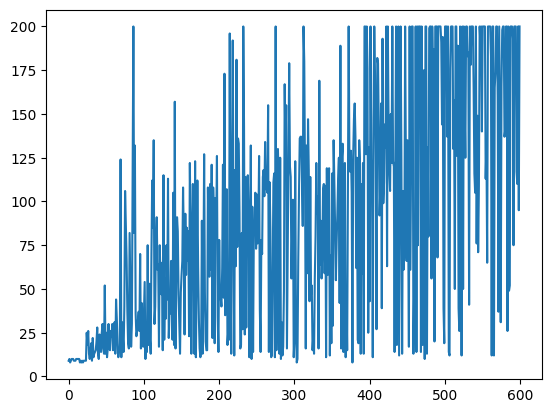

In [189]:
plt.plot(iteration)

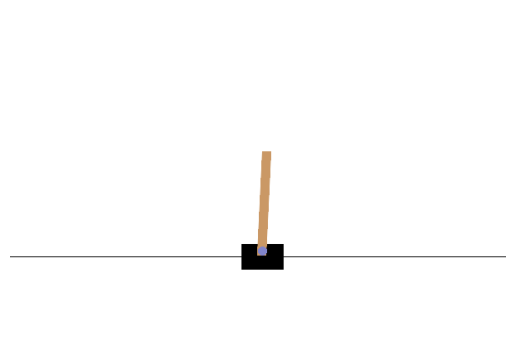

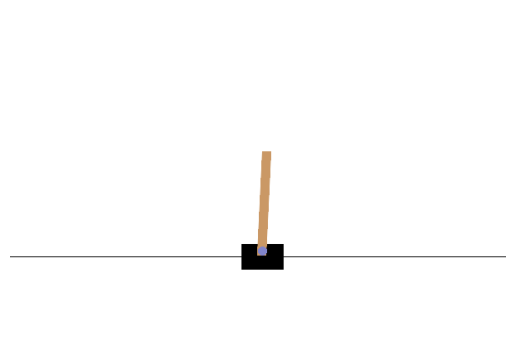

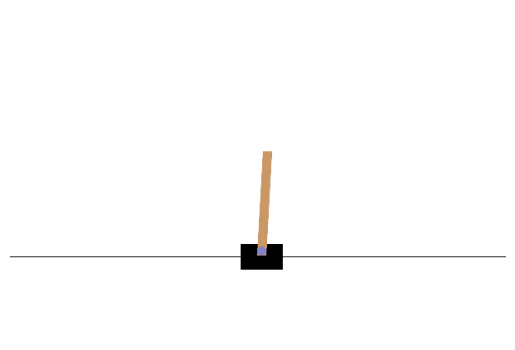

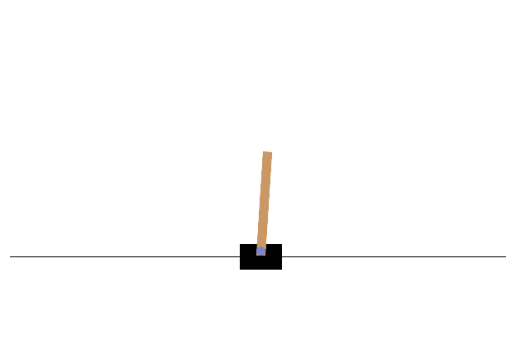

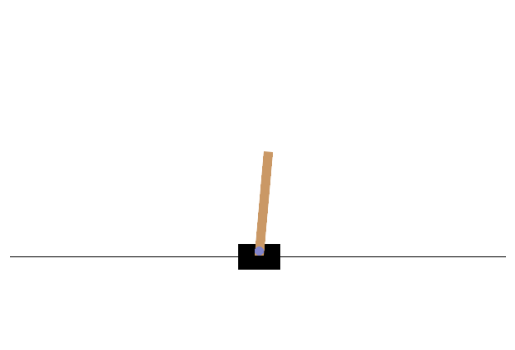

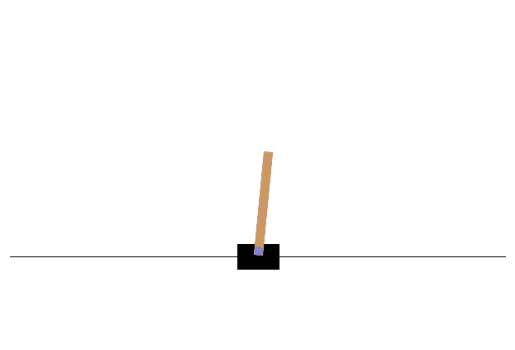

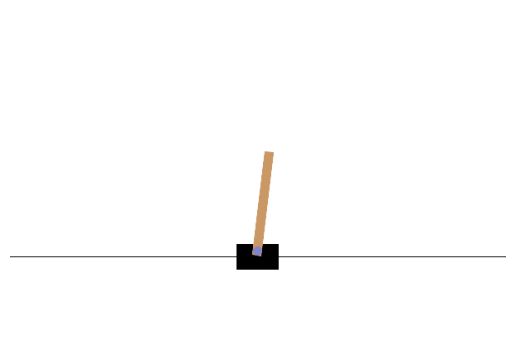

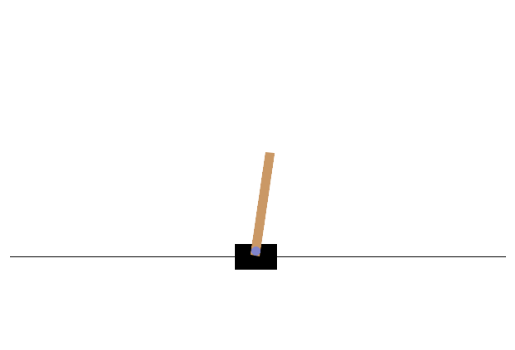

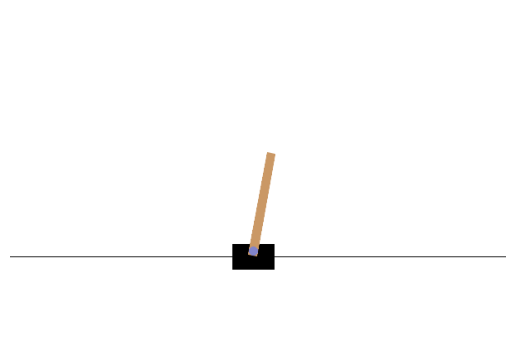

In [190]:
import time

state = env.reset()[0]
done = False


env.reset()
done=False
# img = plt.imshow(env.render()) # only call this once
while not done:
    
    frame = env.render()

    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    action = env.action_space.sample()
    next_state, reward, done, truncated, _=env.step(action)

env.close()

